# Training5

In this notebook file, FirstQuarter-FaceOnly dataset will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

VGG16 pre-trained model will be load and used.

The pre-trained model will be set to non-trainable and will only be used for feature extraction.

Training will only be performed on the fully connected layers and the output layer, that will be added to the end of the pre-trained model.

In this way, the experience gained by the model on very large data sets will be used for this classification problem.

This method is known as [**Transfer Learning**](https://en.wikipedia.org/wiki/Transfer_learning "wikipedia").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#Person dataframe in FirstQuarter is being read from md5 file
personDf = pd.read_pickle("../../../Data/FirstQuarter/Person.pkl")
personDf

,Name
ID,
0,Ahmed Chalabi
1,Ai Sugiyama
2,Alan Greenspan
3,Alastair Campbell
4,Allyson Felix
...,...
107,Wayne Ferreira
108,William Macy
109,Woody Allen


In [5]:
#FaceOnly Training data is being read from md5 file
trainingDf = pd.read_pickle("../../../Data/FirstQuarter/FaceOnly/Training.pkl")
trainingDf

,PersonID,ImageBGR,DetectionType
0,95,"[[[177, 199, 204], [176, 199, 204], [175, 200,...",SingleFace
1,63,"[[[113, 123, 100], [113, 123, 100], [112, 122,...",SingleFace
2,94,"[[[50, 80, 91], [50, 80, 91], [49, 79, 90], [4...",SingleFace
3,10,"[[[122, 123, 114], [124, 125, 116], [128, 129,...",SingleFace
4,101,"[[[90, 109, 124], [92, 110, 126], [95, 113, 13...",SingleFace
...,...,...,...
443,55,"[[[35, 53, 46], [35, 53, 46], [36, 54, 46], [3...",SingleFace
444,79,"[[[147, 152, 153], [147, 151, 152], [148, 151,...",SingleFace
445,54,"[[[68, 70, 64], [65, 68, 62], [60, 63, 58], [5...",SingleFace
446,29,"[[[37, 32, 31], [41, 35, 31], [48, 39, 31], [5...",SingleFace


In [6]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

trainingX = (np.array(trainingDf.ImageBGR.values.tolist()) / 127.5) - 1
trainingX.shape

(448, 224, 224, 3)

In [7]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.PersonID.values.tolist()).reshape((-1,1))
trainingY.shape

(448, 1)

In [8]:
#FaceOnly Validation data is being read from md5 file
validationDf = pd.read_pickle("../../../Data/FirstQuarter/FaceOnly/Validation.pkl")
validationDf

,PersonID,ImageBGR,DetectionType
0,50,"[[[23, 40, 43], [23, 40, 43], [24, 41, 44], [2...",SingleFace
1,73,"[[[48, 51, 56], [48, 51, 56], [47, 50, 55], [4...",SingleFace
2,40,"[[[188, 227, 255], [188, 227, 255], [188, 226,...",SingleFace
3,27,"[[[172, 178, 173], [162, 167, 162], [143, 146,...",SingleFace
4,18,"[[[23, 36, 38], [22, 35, 37], [20, 33, 33], [1...",SingleFace
5,75,"[[[4, 25, 3], [4, 25, 3], [4, 25, 3], [4, 25, ...",SingleFace
6,81,"[[[217, 220, 228], [216, 219, 227], [214, 217,...",SingleFace
7,56,"[[[106, 197, 204], [106, 197, 204], [105, 196,...",SingleFace
8,111,"[[[38, 66, 97], [37, 65, 96], [36, 64, 95], [3...",SingleFace
9,68,"[[[247, 254, 251], [246, 253, 250], [245, 252,...",SingleFace


In [9]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

validationX = (np.array(validationDf.ImageBGR.values.tolist()) / 127.5) - 1
validationX.shape

(55, 224, 224, 3)

In [10]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.PersonID.values.tolist()).reshape((-1,1))
validationY.shape

(55, 1)

In [11]:
#VGG16 pre-trained model is being loaded
#The original VGG16 model was trained with images with size of (224, 224, 3) 
#in BGR color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/vgg/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#Pixel values were converted to [-1, 1] range while preparing trainingX and validationX

#Model is set to non-trainable
#In this way, the convolutional layers that will be used for feature extraction will be used without changing them
#Fully connected layers will be fed the feature-map obtained from the pre-trained convolutional model
#the training process will be performed on this fully connected layers

model = tf.keras.applications.vgg16.VGG16(include_top = False, input_shape = ((224, 224, 3)))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
#The pre-trained model is being connected to the fully connected layer where the training will performed
#A dropout layer is being added to the the model to prevent overfitting,
#and the model is being completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(personDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 112)               229488    
Total params: 70,522,800
Trainable params: 55,808,112
Non-trainable params: 14,714,688
___________________________________

In [13]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [14]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize):
        self.image, self.label = image, label
        self.batchSize = batchSize
        
        #A numpy array for image indexes is being created
        #This array will be used to shuffle the data
        self.index = np.arange(self.image.shape[0])
    
    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return int(np.ceil(self.image.shape[0] / float(self.batchSize)))
    
    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        batchX = self.image[indexPart]
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #At the end of the epoch, the index array is being shuffled 
        #so that the data in the next epoch is returned in different orders
        np.random.shuffle(self.index)

In [15]:
#model is being trained with 50 epochs and 16 batchSize using GPU
#A small batchSize value is being chosen to prevent GPU memory problem
#Large batchSize reduce training time while also generally providing better results
with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, 16),
        epochs = 50,
        validation_data = FitSequence(validationX, validationY, 16)
    )

Epoch 1/50
28/28 [==============================] - 67s 813ms/step - loss: 7.4062 - accuracy: 0.0045 - val_loss: 4.7629 - val_accuracy: 0.0000e+00
Epoch 2/50
28/28 [==============================] - 16s 578ms/step - loss: 4.7072 - accuracy: 0.0223 - val_loss: 4.6150 - val_accuracy: 0.0364
Epoch 3/50
28/28 [==============================] - 16s 577ms/step - loss: 4.2952 - accuracy: 0.0781 - val_loss: 4.3367 - val_accuracy: 0.0545
Epoch 4/50
28/28 [==============================] - 16s 580ms/step - loss: 3.2646 - accuracy: 0.2321 - val_loss: 3.7721 - val_accuracy: 0.1273
Epoch 5/50
28/28 [==============================] - 16s 579ms/step - loss: 1.8614 - accuracy: 0.5089 - val_loss: 3.6992 - val_accuracy: 0.2545
Epoch 6/50
28/28 [==============================] - 16s 582ms/step - loss: 0.8415 - accuracy: 0.7723 - val_loss: 3.7462 - val_accuracy: 0.1273
Epoch 7/50
28/28 [==============================] - 16s 583ms/step - loss: 0.3788 - accuracy: 0.9129 - val_loss: 3.7172 - val_accuracy: 0.

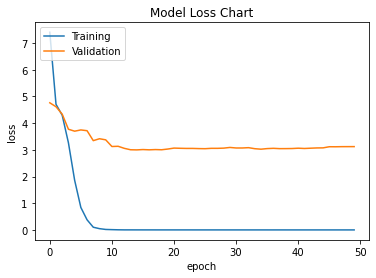

In [16]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

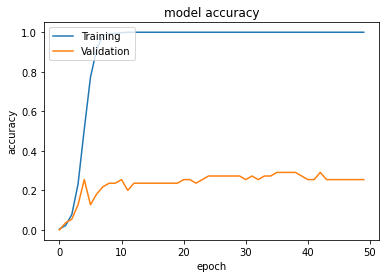

In [17]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [18]:
#FaceOnly Test data is being read from md5 file
testDf = pd.read_pickle("../../../Data/FirstQuarter/FaceOnly/Test.pkl")
testDf

,PersonID,ImageBGR,DetectionType
0,72,"[[[0, 2, 13], [0, 1, 11], [0, 0, 8], [0, 0, 7]...",SingleFace
1,37,"[[[78, 85, 88], [77, 84, 87], [74, 83, 84], [7...",SingleFace
2,21,"[[[100, 19, 11], [100, 19, 11], [100, 19, 11],...",SingleFace
3,104,"[[[80, 59, 114], [80, 59, 114], [81, 59, 113],...",MultipleFace
4,65,"[[[144, 177, 226], [147, 180, 228], [153, 186,...",SingleFace
5,88,"[[[65, 82, 103], [67, 85, 107], [73, 91, 116],...",SingleFace
6,97,"[[[63, 34, 29], [63, 35, 30], [62, 36, 33], [6...",SingleFace
7,87,"[[[84, 81, 83], [86, 81, 82], [88, 82, 83], [8...",NoFace
8,105,"[[[2, 4, 112], [2, 4, 112], [2, 4, 112], [2, 4...",SingleFace
9,67,"[[[89, 100, 98], [82, 93, 91], [68, 79, 77], [...",SingleFace


In [19]:
#testX is being extracted from testDf as wanted shape
#Pixel values are being converted  to the [-1, 1] range with the simplest method (pixel / 127.5 - 1)
testX = (np.array(testDf.ImageBGR.values.tolist()) / 127.5) - 1
testX.shape

(57, 224, 224, 3)

In [20]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.PersonID.values.tolist()).reshape((-1,1))
testY.shape

(57, 1)

In [21]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, 16))

4/4 [==============================] - 9s 3s/step - loss: 4.0729 - accuracy: 0.2982


In [22]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 4.072862148284912


In [23]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.2982456088066101


# Training5 Inference

By looking at the charts, it can be said that training results in overfitting.

A similar architecture was trained with same data in the Training1 notebook file without the Transfer Learning method.

Although the results are much better than those in the Training1 notebook file, a success of about 29% on the Validation data and about 100% on the Training data indicates overfitting.

In this case, it can be said that overfitting is caused by too few images for each person.

This example clearly demonstrates the power of Transfer Learning.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.

Since there is no expectation from this dataset, which contains very few images for each Person.

This training will not be focussed on.